In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skewnorm, skew
import matplotlib.pyplot as plt
from sympy import Symbol
from sympy.solvers import solve

In [3]:
np.random.seed(42)

In [4]:
def delta_fn(alpha):
    delta = alpha/(1+alpha**2)**(0.5)
    return(delta)

def skewness_fn(alpha):
    delta = delta_fn(alpha)
    first_term = (4.-np.pi)/2.
    num = (delta * (2./np.pi)**0.5)**3.
    denom = (1-(2.*delta**2/np.pi))**(1.5)
    second_term = num/denom
    return first_term * second_term

def variance_fn(alpha, omega=1):
    delta = delta_fn(alpha)
    return omega**2 * (1-(2*delta**2)/np.pi)
    
def mean_fn(alpha, omega=1, xi=0):
    delta = delta_fn(alpha)
    return xi + omega * delta * np.sqrt(2/np.pi)

def alpha_solver(skewness=0):
  if skewness==0:
    return 0
  elif abs(skewness) > 1:
    raise ValueError('No Real Solutions when abs(skewness) > 1!')
  else: 
    alpha = Symbol('alpha')
    return float(solve(skewness_fn(alpha)-skewness, alpha)[0])

def omega_solver(alpha, variance=1):
    delta = delta_fn(alpha)
    return float((variance / (1.-(2.*delta**2)/np.pi))**(1/2.))

def xi_solver(alpha, omega, mean=0):
    delta = delta_fn(alpha)
    return float(mean - omega*delta*np.sqrt(2/np.pi))

class SkewNorm:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.get_stats()
        self.gen_sim()
    def get_stats(self):
        self.stats = skewnorm.stats(self.alpha, loc=self.xi, scale=self.omega, moments='mvsk')
    def gen_sim(self, size=None):
        if size:
            self.sim_size = size
        else:
            size = self.sim_size
        self.sim = sorted(skewnorm.rvs(self.alpha, loc=self.xi, scale=self.omega, size=size))
        
def skewnorm_solver(skewness=0, variance=1, mean=0):
    alpha = alpha_solver(skewness)
    alpha_check = skewness_fn(alpha)
    assert abs(alpha_check - skewness) < 1e-6

    omega = omega_solver(alpha,variance)
    omega_check = variance_fn(alpha, omega)
    assert abs(omega_check - variance) < 1e-6

    xi = xi_solver(alpha, omega, mean)
    xi_check = mean_fn(alpha, omega, xi)
    assert abs(xi_check - mean) < 1e-6
    res = SkewNorm(alpha=alpha, omega=omega, xi=xi, sim_size=10000, hist_bins=100)
    assert abs(res.stats[0] - mean) < 1e-6
    assert abs(res.stats[1] - variance) < 1e-6
    assert abs(res.stats[2] - skewness) < 1e-6
    return res

A distribution from the **skewnormal** family is uniquely specified by a combination of $\alpha$, the **shape** parameter, $\omega$, the **scale** parameter and $\xi$, the **location** parameter.

The following equations are written in terms of $\delta$, which is a univariate function of $\alpha$, the shape parameter of the skewnormal distribution.

$ \delta = \frac{\alpha}{\sqrt{1+\alpha^2}} $

First we must solve for the shape parameter by solving for delta in the following equation that defines the skewness $(\gamma_1)$ in terms of $\delta$.

$ \gamma_1 (X) = \frac{4-\pi}{2} \frac{(\delta\sqrt{(2/\pi})^3}{(1-2\delta^2/\pi)^\frac{3}{2}} $

Then, given the fixed $\delta$ we have solved for in the previous section, we can solve for $\omega$ as a univariate function of $Var(X)$.

$ Var(X) = \omega^2 (1-\frac{2\delta^2}{\pi}) $

Finally, given $\alpha$ (and thereby $\delta$) and $\omega$ we can solve for $\xi$ to fit our desired mean.

$ E(X) = \xi + \omega\delta \sqrt{\frac{2}{\pi}} $

In [122]:
variations = {
    'intro': {'skewness':0, 'variance': np.log(1.10)**2, 'mean': np.log(50)},
    'control': {'skewness':0, 'variance': np.log(1.10)**2, 'mean': np.log(100)},
    'high_variance': {'skewness':0, 'variance': np.log(1.15)**2, 'mean': np.log(100)},
    'right_skew': {'skewness':0.5, 'variance': np.log(1.10)**2, 'mean': np.log(100)},
    'left_skew': {'skewness':-0.5, 'variance': np.log(1.10)**2, 'mean': np.log(100)},
    'right_skew_hiv': {'skewness':0.5, 'variance': np.log(1.15)**2, 'mean': np.log(100)},
    'left_skew_hiv': {'skewness':-0.5, 'variance': np.log(1.15)**2, 'mean': np.log(100)},
}

distributions = {k: skewnorm_solver(**v).sim for k,v in variations.items()}
log_df = pd.DataFrame(distributions)
df = np.exp(log_df)

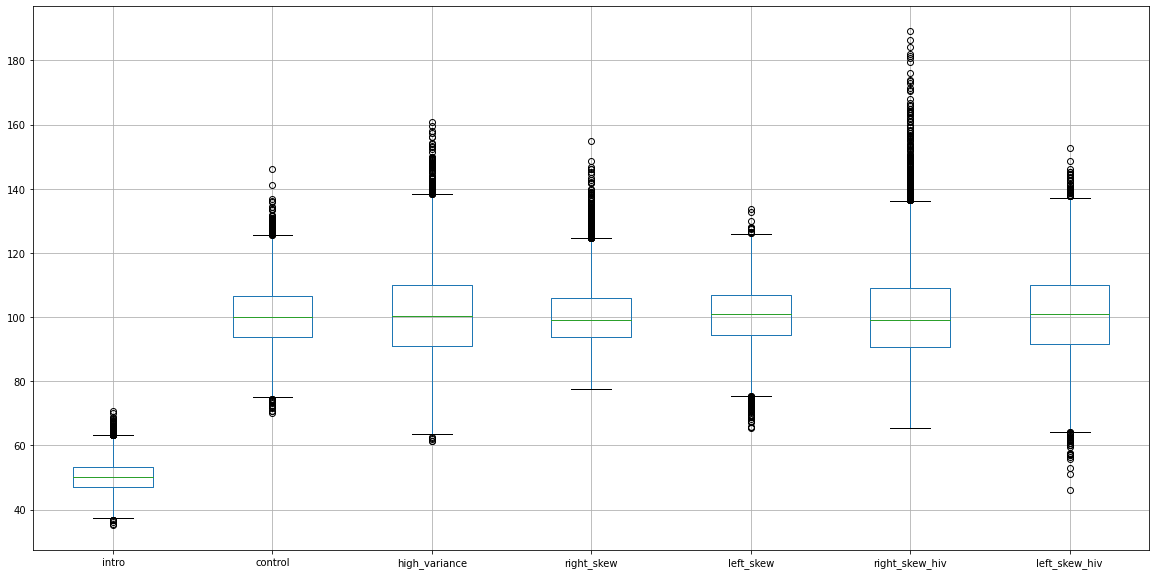

In [123]:
df.boxplot(figsize=(20,10))

In [124]:
print(df.quantile(0.05, interpolation='lower'))

df.loc[:499].mean()

intro            $42.66
control          $85.59
high_variance    $79.71
right_skew       $86.91
left_skew        $84.30
right_skew_hiv   $81.36
left_skew_hiv    $77.78
Name: 0.05, dtype: float64


intro            $41.10
control          $82.28
high_variance    $75.08
right_skew       $84.41
left_skew        $79.95
right_skew_hiv   $78.26
left_skew_hiv    $72.04
dtype: float64

In [125]:
print(df.quantile(0.95, interpolation='lower'))
df.loc[9499:].mean()

intro             $58.44
control          $116.66
high_variance    $125.73
right_skew       $118.02
left_skew        $115.14
right_skew_hiv   $128.10
left_skew_hiv    $122.66
Name: 0.95, dtype: float64


intro             $61.00
control          $121.33
high_variance    $133.49
right_skew       $124.60
left_skew        $118.44
right_skew_hiv   $139.06
left_skew_hiv    $128.22
dtype: float64

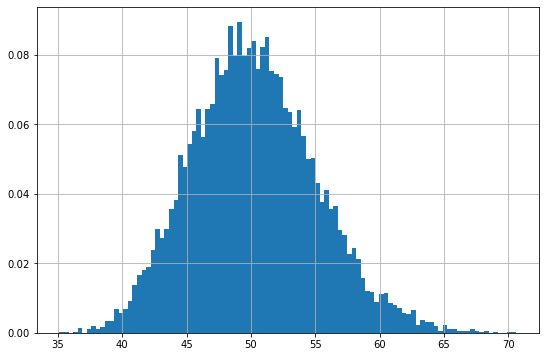

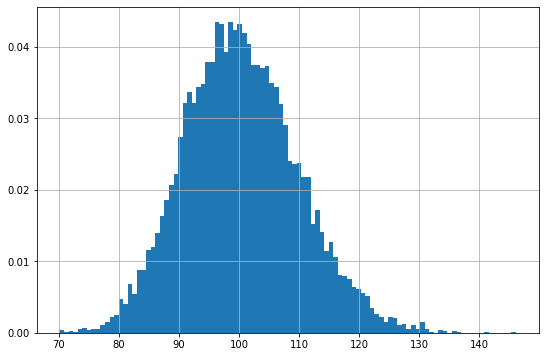

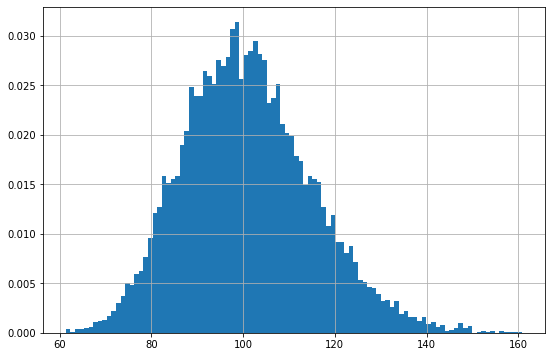

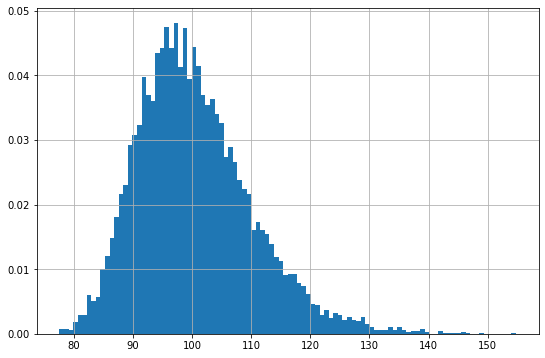

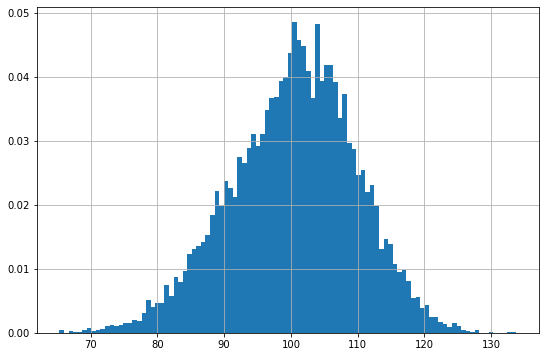

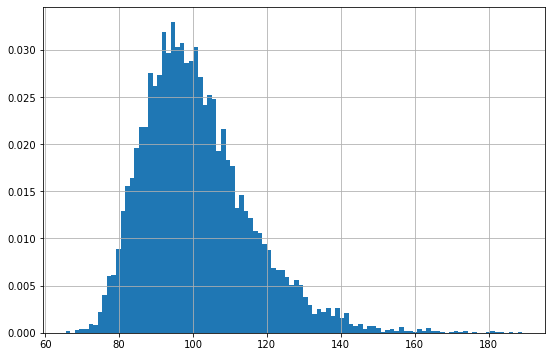

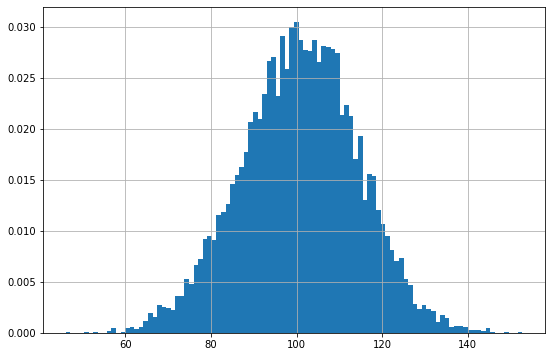

In [127]:
for i, col in enumerate(df.columns):
    fig, axs = plt.subplots(1, figsize=(9, 6))
    df[col].hist(ax=axs, bins=100, density=True)
    fig.savefig('survey_content/{}/histogram.png'.format(col))

In [130]:
from scipy.stats import skew, mode

def skew_str(s):
    return str(round(skew(s),2))

quantiles = {}
conditional_means = {}
stats = {}
for col in df.columns:
    tmp = df[col]
    quantiles[col] = tmp.quantile([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])
    conditional_means[col] = pd.Series(dtype=object)
    for quantile in quantiles[col].index.tolist():
        if quantile != 0.5:
            val = quantiles[col][quantile]
            conditional_means[col][quantile] = (tmp.loc[tmp < val].mean() * (quantile < 0.5) +
                                                tmp.loc[tmp > val].mean() * (quantile > 0.5))
    stats[col] = pd.Series(dtype=object)
    for stat in [np.mean, np.median, np.std, skew_str]:
        stats[col][stat.__name__] = stat(tmp)
    stats[col].rename({'std':'std deviation', 'skew_str':'skewness'}, inplace=True)
    quantiles[col].rename({0.01: '1%', 0.05: '5%', 0.1:'10%', 0.25:'25%', 0.5:'50%', 0.75:'75%', 0.9:'90%',
                  0.95: '95%', 0.99:'99%'}, inplace=True)
    conditional_means[col].rename({0.01: '1%', 0.05: '5%', 0.1:'10%', 0.25:'25%', 0.5:'50%', 0.75:'75%', 0.9:'90%',
              0.95: '95%', 0.99:'99%'}, inplace=True)
    quantiles[col].to_frame(name='Prices').to_html('survey_content/{}/quantiles.html'.format(col))
    conditional_means[col].to_frame(name='Average of Price Tails').to_html('survey_content/{}/cond_means.html'.format(col))
    stats[col].to_frame(name='Statistics').to_html('survey_content/{}/stats.html'.format(col))

In [131]:
import weasyprint as wsp
import PIL as pil


def trim(source_filepath, target_filepath=None, background=None):
    if not target_filepath:
        target_filepath = source_filepath
    img = pil.Image.open(source_filepath)
    if background is None:
        background = img.getpixel((0, 0))
    border = pil.Image.new(img.mode, img.size, background)
    diff = pil.ImageChops.difference(img, border)
    bbox = diff.getbbox()
    img = img.crop(bbox) if bbox else img
    img.save(target_filepath)


for col in df.columns:
    quantile_html = open('survey_content/{}/quantiles.html'.format(col)).read()
    means_html = open('survey_content/{}/cond_means.html'.format(col)).read()
    stats_html = open('survey_content/{}/stats.html'.format(col)).read()
    quantile_png = 'survey_content/{}/quantiles.png'.format(col)
    means_png = 'survey_content/{}/cond_means.png'.format(col)
    stats_png = 'survey_content/{}/stats.png'.format(col)
    css = wsp.CSS(string='''
    @page { size: 200px100px; padding: 0px; margin: 0px; }
    table, td, tr, th { border: 1px solid black; }
    td, th { padding: 4px 8px; }
    ''')
    quantile_wsp = wsp.HTML(string=quantile_html)
    quantile_wsp.write_png(quantile_png, stylesheets=[css])
    means_wsp = wsp.HTML(string=means_html)
    means_wsp.write_png(means_png, stylesheets=[css])
    stats_wsp = wsp.HTML(string=stats_html)
    stats_wsp.write_png(stats_png, stylesheets=[css])
    trim(means_png)
    trim(quantile_png)
    trim(stats_png)